<a href="https://colab.research.google.com/github/AbdouJaouhar/greenshield_internship/blob/master/Stage_Martell_Prise_en_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [1]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?code_challenge=euYQH5W5vQ5oDumQZ3Sp518CULt9ikt0-e8mnj5YXAk&prompt=select_account&code_challenge_method=S256&access_type=offline&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth


Enter verification code: 4/ygG-GZyNALAKF5m5kCihL3N4hrEebZOf1B-dFScktAk3-hk0B8Khnmg

You are now logged in as [abdou.jaouhar@greenshield.fr].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [2]:
!wget https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64 -O cloud_sql_proxy
!chmod +x cloud_sql_proxy   

--2020-04-10 09:23:37--  https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64
Resolving dl.google.com (dl.google.com)... 74.125.20.190, 74.125.20.136, 74.125.20.91, ...
Connecting to dl.google.com (dl.google.com)|74.125.20.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14492253 (14M) [application/octet-stream]
Saving to: ‘cloud_sql_proxy’

cloud_sql_proxy     100%[===================>]  13.82M  --.-KB/s    in 0.04s   

2020-04-10 09:23:37 (327 MB/s) - ‘cloud_sql_proxy’ saved [14492253/14492253]



In [3]:
!nohup ./cloud_sql_proxy -instances=smooth-maxim-228913:europe-west1:datalex-sql=tcp:3307 &

nohup: appending output to 'nohup.out'


In [7]:
!pip install pymysql

     |████████████████████████████████| 51kB 2.6MB/s 


In [8]:
!pip install chart_studio

# DatAlex

In [9]:
import os
import pandas as pd
import numpy as np
import pymysql
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import datetime
import seaborn as sns

import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)


py.sign_in('jawarbinks', '6JZPr60TfXzxurY9Hc1A')

import plotly.io as pio
pio.renderers.default = 'colab'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class DatAlex(object):
    def __init__(self):
        pass

    def connect(self):
        os.system('nohup ./cloud_sql_proxy -instances=smooth-maxim-228913:europe-west1:datalex-sql=tcp:3307 &')
        self.connection = pymysql.connect(host='127.0.0.1', port=3307, user='greenshield', password='bnghty56', db='DatAlex_v3_5')
        self.cursor = self.connection.cursor()

    def get_answer(self, query):
        self.cursor.execute(query)
        answer = self.cursor.fetchall()

        # print(query.split("SELECT")[1].split("FROM")[0].split(','))
        return answer

    def get_all_datas(self):
        query = "SELECT A3.name, A4.name, A2.date, A2.stage FROM bioagr_measures A1, pheno_measures A2, parcels A3, domains A4 WHERE A3.id_parc=A1.id_parc AND A2.id_pheno=A1.id_pheno AND A4.id_domain=A3.id_domain ORDER BY A2.date;"
        self.cursor.execute(query)
        answers = np.array(self.cursor.fetchall())

        return answers


    def get_parcel_history(self, parcel_name):
        query = "SELECT A3.name, A2.date, A2.stage, A1.mildew_leaves, A1.mildew_bunches FROM bioagr_measures A1, pheno_measures A2, parcels A3 WHERE YEAR(A2.date)="+str(annee)+" AND A3.id_parc=A1.id_parc AND A2.id_pheno=A1.id_pheno AND A3.name LIKE '%"+parcel_name+"%' ORDER BY A2.date;"
        return self.get_answer(query)


datalex = DatAlex()
datalex.connect()

# First Try

In [11]:
all_datas = datalex.get_all_datas()
all_parc_names = np.unique(np.array(all_datas)[:,0])
all_parc_domains = {}

def getAllParcelNamesWithAGivenString(name):
    return all_parc_names[np.array([name in s for s in all_parc_names])]

for n in all_parc_names:
    all_parc_domains[n] = all_datas[all_datas[:,0]==n,1][0]


annee = 2019

nom = "gandourie" 

query = "SELECT \
            A3.name, A2.date, A2.stage, A1.mildew_leaves, A1.mildew_bunches, A2.pluvio \
        FROM \
            bioagr_measures A1, pheno_measures A2, parcels A3, gen_measures A4 \
        WHERE \
            A4.date=A2.date \
            AND A4.id_domain=A2.id_dom \
            AND YEAR(A2.date)="+ str(annee) +" \
            AND A3.id_parc=A1.id_parc \
            AND A2.id_pheno=A1.id_pheno \
            AND A3.name LIKE '%"+nom+"%' \
        ORDER BY A2.date;"

gandourie = np.array(datalex.get_answer(query))
gandourie[:,0] = [nom for i in range(gandourie.shape[0])]
print(gandourie.shape)
naudin_parc_names = getAllParcelNamesWithAGivenString(nom)
naudin_parc_dates = {}
naudin_parc_stage = {}
naudin_pluvio = {}
naudin_mildew_leaves = {}
naudin_mildew_bunches = {}

for nn in naudin_parc_names:
    naudin_parc_dates[nn] = gandourie[gandourie[:,0]==nn,1]    
    naudin_parc_stage[nn] = gandourie[gandourie[:,0]==nn,2]
    naudin_pluvio[nn] = gandourie[gandourie[:,0]==nn,5]
    naudin_mildew_bunches[nn] = gandourie[gandourie[:,0]==nn,4]
    naudin_mildew_leaves[nn] = gandourie[gandourie[:,0]==nn,3]




weeks = np.zeros((len(naudin_parc_dates),52))
parcels_used = []
for i, parcel in enumerate(naudin_parc_dates.keys()):
    if len(naudin_parc_stage[parcel])!=0:
        for stage, date in zip(naudin_parc_stage[parcel], naudin_parc_dates[parcel]):
            if "-" in stage:
                weeks[i,date.isocalendar()[1]] = np.array(stage.split('-')).astype(np.float).mean()
            else:
                weeks[i,date.isocalendar()[1]] = float(stage)
        parcels_used.append(i)

min_date, max_date = min(gandourie[:,1]).isocalendar()[1],max(gandourie[:,1]).isocalendar()[1]
fig = px.imshow(weeks[parcels_used,min_date:max_date])
                # labels=dict(x="Week of year " + str(annee), y="Time of Day", color="Productivity"),
                # x = [i for i in range(min_date, max_date)])

fig.update_xaxes(side="top")
iplot(fig)

import re

weeks = np.zeros((len(naudin_parc_dates),52))
parcels_used = []
for i, parcel in enumerate(naudin_parc_dates.keys()):
    if len(naudin_parc_stage[parcel])!=0:
        for pluvio, date in zip(naudin_pluvio[parcel], naudin_parc_dates[parcel]):
            # print(pluvio)
            # print(pluvio)
            # print(i,pluvio)
            # print("\t",  re.sub("[^0-9]", " ", pluvio).split("-")[0])
            if pluvio == "nan":
                weeks[i,date.isocalendar()[1]] = np.nan
            elif "touv0" in pluvio:
                weeks[i,date.isocalendar()[1]] = 0
            else:
                # print(pluvio)
                # print(re.sub("[^0-9]", " ", "touv0").split(" ")[0])
                weeks[i,date.isocalendar()[1]] = re.sub("[^0-9^]", " ", pluvio).split(" ")[0]
        parcels_used.append(i)

min_date, max_date = min(gandourie[:,1]).isocalendar()[1],max(gandourie[:,1]).isocalendar()[1]
fig = px.imshow(weeks[parcels_used,min_date:max_date])
                # labels=dict(x="Week of year " + str(annee), y="Time of Day", color="Productivity"),
                # x = [i for i in range(min_date, max_date)])

fig.update_xaxes(side="top")
iplot(fig)


weeks = np.zeros((len(naudin_parc_dates),52))
parcels_used = []

mildew_to_number = {'RAS' : 0, 'QT' : 1, 'RT' : 2, 'BT' : 3}
for i, parcel in enumerate(naudin_parc_dates.keys()):
    if len(naudin_mildew_leaves[parcel])!=0:
        for stage, date in zip(naudin_mildew_leaves[parcel], naudin_parc_dates[parcel]):
            # print(stage)
            if 'RAS' in stage:
                weeks[i,date.isocalendar()[1]] = 0
            elif 'QT' in stage:
                weeks[i,date.isocalendar()[1]] = 1
            elif 'RT' in stage:
                weeks[i,date.isocalendar()[1]] = 2
            elif 'BT' in stage:
                weeks[i,date.isocalendar()[1]] = 3
            elif 'freq' in stage and 'Int' in stage and '2010' not in stage:
                freq = np.array(stage.split('%')[0].split("=")[1].split('-')).astype(np.float).mean()/100
                inty = np.array(stage.split('%')[1].split("=")[1].split('-')).astype(np.float).mean()/100
                weeks[i,date.isocalendar()[1]] = int(4*inty)
            elif 'Freq' in stage and 'int' in stage and '2010' not in stage:
                # print(stage.split(';')[0].split(":")[1].split("%")[0])
                freq = np.array(stage.split(';')[0].split(":")[1].split("%")[0].split('-')).astype(np.float).mean()/100
                inty = np.array(stage.split(';')[1].split(":")[1].split("%")[0].split('-')).astype(np.float).mean()/100
                weeks[i,date.isocalendar()[1]] = int(4*inty)
            elif 'freq' in stage and 'int' in stage and '2010' not in stage:

                if "=" in stage:
                    symb = "="
                elif ":" in stage:
                    symb = ":"
                else:
                    symb = ":"
                freq = np.array(stage.split('%')[0].split("=")[1].split('-')).astype(np.float).mean()/100
                inty = np.array(stage.split('%')[1].split("=")[1].split('-')).astype(np.float).mean()/100
                weeks[i,date.isocalendar()[1]] = int(4*inty)
                
                weeks[i,date.isocalendar()[1]] = int(4*inty)
            elif 'freq' in stage and 'int' in stage and '2010' in stage:
                inty = np.array(stage.split(';')[0].split("/")[1].split(' ')[1][1:]).astype(np.float).mean()/100
                weeks[i,date.isocalendar()[1]] = int(4*inty)
            elif "MFI" in stage:
                inty = float(stage.split('MFI')[1].split('%')[0])/100
                weeks[i,date.isocalendar()[1]] = int(4*inty)
            elif "bcp" in stage:
                weeks[i,date.isocalendar()[1]] = 3
            elif " coté chemin blanc" in stage:
                weeks[i,date.isocalendar()[1]] = 2
            else:
                print("Err : ", stage)
                weeks[i,date.isocalendar()[1]] = 0
        parcels_used.append(i)

min_date, max_date = min(gandourie[:,1]).isocalendar()[1],max(gandourie[:,1]).isocalendar()[1]
fig = px.imshow(weeks[parcels_used,min_date:max_date])
                # labels=dict(x="Week of year " + str(annee), y="Time of Day", color="Productivity"),
                # x = [i for i in range(min_date, max_date)])

fig.update_xaxes(side="top")
iplot(fig)


weeks = np.zeros((len(naudin_parc_dates),52))
parcels_used = []

mildew_to_number = {'RAS' : 0, 'QT' : 1, 'RT' : 2, 'BT' : 3}
for i, parcel in enumerate(naudin_parc_dates.keys()):
    if len(naudin_mildew_bunches[parcel])!=0:
        for stage, date in zip(naudin_mildew_bunches[parcel], naudin_parc_dates[parcel]):
            # print(stage)
            if 'RAS' in stage:
                weeks[i,date.isocalendar()[1]] = 0
            elif 'QT' in stage:
                weeks[i,date.isocalendar()[1]] = 1
            elif 'RT' in stage:
                weeks[i,date.isocalendar()[1]] = 2
            elif 'BT' in stage:
                weeks[i,date.isocalendar()[1]] = 3
            elif 'freq' in stage and 'int' in stage and '2010' not in stage:

                if "=" in stage:
                    symb = "="
                elif ":" in stage:
                    symb = ":"
                else:
                    symb = ":"
                freq = np.array(stage.split('%')[0].split(symb)[1].split('-')).astype(np.float).mean()/100
                inty = np.array(stage.split('%')[1].split(symb)[1].split('-')).astype(np.float).mean()/100
                weeks[i,date.isocalendar()[1]] = int(4*inty)
            elif 'freq' in stage and '2010' in stage:
                # print(stage)
                # print(stage.split(';')[0].split(':'))
                inty = np.array(stage.split(';')[0].split(':')[3].split(" ")[0]).astype(np.float).mean()/100
                weeks[i,date.isocalendar()[1]] = int(4*inty)
            elif stage == " 100 % de grappes touchées sur les 2009 et les 2010 et bois de gandourie":
                weeks[i,date.isocalendar()[1]] = 3
            elif stage == "30 à 50 % de grappes touchées sur les 2009 et les 2010 et bois de gandourie" or "20 à 30 % de grappes touchées sur les 2009 partie haute":
                weeks[i,date.isocalendar()[1]] = 2
            elif stage == "90 à 100 % de grappes touchées sur les 2009 et les 2010 et bois de gandourie":
                weeks[i,date.isocalendar()[1]] = 3
            else:
                print("Erreur : ", stage)
                weeks[i,date.isocalendar()[1]] = np.nan
        parcels_used.append(i)

min_date, max_date = min(gandourie[:,1]).isocalendar()[1],max(gandourie[:,1]).isocalendar()[1]
fig = px.imshow(weeks[parcels_used,min_date:max_date])
                # labels=dict(x="Week of year " + str(annee), y="Time of Day", color="Productivity"),
                # x = [i for i in range(min_date, max_date)])

fig.update_xaxes(side="top")
iplot(fig)

# plt.plot(weeks[parcels_used,min_date:max_date][0], "*")
# plt.show()
# weeks[parcels_used,min_date:max_date]

(22, 6)


Err :  nan
Err :  nan
Err :  nan
Err :  nan
Err :  nan


# Cleaning DatAlex

In [149]:
query = "SELECT \
            A3.name, A2.date, A2.gab_arcures, A1.mites, A1.pow_mildew_bunches, A2.pluvio \
        FROM \
            bioagr_measures A1, pheno_measures A2, parcels A3, gen_measures A4 \
        WHERE \
            A4.date=A2.date \
            AND A4.id_domain=A2.id_dom \
            AND A3.id_parc=A1.id_parc \
            AND A2.id_pheno=A1.id_pheno \
        ORDER BY A2.date;"

gandourie = np.array(datalex.get_answer(query))

np.isin(gandourie[:,3], ['ras','RAS', 'RT', 'QT', 'BT']).shape
# gandourie[:,3]

(3889,)

In [0]:
import re

def case_from_freq_int(state):
    state = [s.replace("%", "") for s in state]
    if len(state) == 2:
        howmuch = float(state[0])*float(state[1])/10000
    if len(state) == 4:
        howmuch = (float(state[0])*float(state[1])/10000 + float(state[2])*float(state[3])/10000)/2

    if howmuch == 0:
        return 'RAS'
    elif howmuch >0 and howmuch <=20:
        return 'RT'
    elif howmuch >20 and howmuch <= 40:
        return 'QT'
    elif howmuch > 40 and howmuch <= 80:
        return 'BT'

#fonctionne aussi pour pow_mildew_leaves et pow_mildew_bunches
def mildew_blackrot_processing(cell):

    state_to_num = {'RAS' : 0, 'RT' : 1, 'QT' : 2, 'BT' : 3, 'nan' : np.nan}
    m = None
    cell = cell.replace(" ", "").lower()

    if re.match(r'freq.*?\d+%.*?int.*?\d+%', cell):
        m = re.findall(r"\d+%", cell)
        new_val = case_from_freq_int(m)


    elif re.match(r'mff.*?\d+%.*?mfi.*?\d+%', cell):
        m = re.findall(r'\d+%', cell)
        new_val = case_from_freq_int(m)
    elif re.match(r'mff.*?\d+.*?-.*?\d+.*?%.*?mfi.*?\d+.*?%.*?', cell):
        m = re.findall(r'\d+%', cell)
        new_val = case_from_freq_int(m)

    elif re.match(r'mgf.*?\d+%.*?mgi.*?\d+%', cell):
        m = re.findall(r'\d+%', cell)
        new_val = case_from_freq_int(m)
    elif re.match(r'mgf\d+-\d+%;mgi\d+%', cell):
        m = re.findall(r'\d+%', cell)
        new_val = case_from_freq_int(m)


    elif re.match(r'freq.*?\d+%;int.*?\d+-\d+%', cell):
        m = re.findall(r'\d+%', cell)
        new_val = case_from_freq_int(m)

    elif re.match(r'2010-11:freq:\d+%/int:\d+%;2009:freq:\d+%/int\d+%', cell):
        m = re.findall(r'\d+%', cell)
        new_val = case_from_freq_int(m)
    elif re.match(r'\d+feuillesparentredeux', cell):
        m = re.findall(r'\d+', cell)
        new_val = 'QT'
    elif re.match(r'\d+-\d+feuillesparentredeux', cell):
        m = re.findall(r'\d+-', cell)
        new_val = 'QT'
        
        # print(cell)
    elif cell in ['rg', 'bg', 'qt']:
        new_val = cell[0].upper() +'T'
    elif cell in ['tt']:
        new_val = 'RT'
    elif 'rt' in cell or cell=='1' or cell == '3dans2009' or cell == '3côtéligneàhtension' or cell == "1tache" or cell == "1t" or cell == "2t":
        new_val = 'RT'
    elif 'bt' in cell or cell == 'bcp':
        new_val = 'BT'
    elif 'qt' in cell or 'quelquesbaiestouchées' == cell or 'stabilisationquelquesbaiestouchées' == cell or 'quelquesgrappestouchéesauniveaudupuit' ==cell or 'bcpgrappestouchéesrotgrisetrotbrun' ==cell:
        new_val = 'QT'
    elif 'non' == cell or '-' == cell or '/' == cell or 'observationimpossiblecargrossepluie' == cell:
        new_val = 'nan'
    elif 'quelquesgrappestouchées' == cell or '1gpstouchee' == cell or cell == '1baiesdetouchées':
        new_val = 'RT'
    elif 'ras' in cell:
        new_val = 'RAS'
    elif re.match(r'gmg:freq\d+%;int:\d+-\d%', cell):
        m = re.findall(r'\d+%', cell)
        new_val = case_from_freq_int(m)
    else:
        new_val = 'nan'

    
    return state_to_num[new_val]


#leafhopper nothing to do
def leafrollers_processing(cell):
    return 'nan'

def mites_processing(cell):
    state_to_num = {'Aca' : 0, 'ER' : 1, 'AR' : 2, 'AJ' : 3, 'nan' : np.nan}
    if cell == 'Erinose':
        new_val =  'ER'
    elif cell == 'Aca':
        new_val =  'Aca'
    elif cell == 'Aca?':
        new_val =  'Aca'
    else:
        new_val =  'nan'

    return state_to_num[new_val]
def botrytis_processing(cell):
    state_to_num = {'RF' : 0, 'QF' : 1, 'nan' : np.nan}
    if 'QF' in cell:
        new_val = 'QF'
    elif 'RT' in cell:
        new_val = 'RF'
    elif cell == '1 feuille':
        new_val = 'RF'
    elif 'BF' in cell:
        new_val = 'BF'
    else:
        new_val = 'nan'

    return state_to_num[new_val]


def sprout_processing(cell):
    cell = cell.replace(' ', '')
    if cell == '-' or cell == "mesuredepousseimpossiblecasséesparl'oragedegrele" or cell == 'lapousseestdésséchéesurlapointe':
        new_val = 'nan'
    elif 'cm' in cell:
        new_val = cell.split("cm")[0]
    elif cell == 'plusdepousse(gréle)etessolépourlepaysbas' or "1erreleveaujourd'hui" == cell or 'poussesgrêlées' == cell:
        new_val = '0'
    elif cell == '3,6mm/jour':
        new_val = '0.36'
    elif '(poussedéséchéeenbout)' in cell:
        new_val = cell.split('(')[0]
    elif '1,6poussemoyennedelasemaine' == cell:
        new_val = '0.22'
    else: 
        new_val = cell

    return np.float(new_val.replace(',', '.'))


def wood_disease_processing(cell):
    state_to_num = {'E' : 0, 'EEB' : 1, 'EB' : 2, 'nan' : np.nan}
    if 'pieds observés' in cell:
        return 'nan'
    else:
        return cell.replace(' ', '').replace('/', '').replace(',', '').replace('+', '')
def pluvio_processing(cell):
    if '(' in cell:
        return np.float(cell.split('(')[0].replace(',', '.'))
    elif 'touv0' == cell:
        return 0.0
    else:
        return np.float(cell.replace(',', '.'))


def gab_processing(cell):
    cell = cell.replace(' ', '').replace('m', '').replace("'", "")
    if cell == "('nan', 'nan')":
        if "'" in cell:
            new_val = np.float(cell.split("'")[1])*np.float(cell.split("'")[3])
        else:
            new_val = np.float(cell.split(",")[0].replace('(', ''))*np.float(cell.split(",")[1].replace(')', ''))
    else:
        if 'c' not in cell:
            cell = cell.replace('c', '')
            
        L = np.float(re.findall('\((.*?), (.*?)\)', cell)[0][0].replace("\'", ""))
        H = np.float(re.findall('\((.*?), (.*?)\)', cell)[0][1])
        new_val = L*H
    
    return new_val

In [0]:
import requests
import json

In [0]:
query = "SELECT \
            A3.name, A5.name, A2.date, A1.mildew_leaves, A1.mildew_bunches, A2.stage, A2.sprout\
        FROM \
            bioagr_measures A1, pheno_measures A2, parcels A3, gen_measures A4, domains A5 \
        WHERE \
            A4.date=A2.date \
            AND A5.id_domain=A2.id_dom \
            AND A4.id_domain=A2.id_dom \
            AND A3.id_parc=A1.id_parc \
            AND A2.id_pheno=A1.id_pheno \
            AND YEAR(A2.date) > 2011 \
        ORDER BY A2.date;"
        #OR A5.name LIKE '%magdeleine%') \

def stage_processing(cell):
    return np.mean([np.float(c) for c in cell.split('-')])

# del gandourie

gandourie = np.array(datalex.get_answer(query))
gandourie = pd.DataFrame(data=gandourie, columns=['parcel_name', 'domain_name', 'date', 'mildew_leaves', 'mildew_bunches', 'stage', 'sprout'])
# a = gandourie[:,3].apply(pluvio_processing)
gandourie.iloc[:,3] = gandourie.iloc[:,3].apply(mildew_blackrot_processing)
gandourie.iloc[:,4] = gandourie.iloc[:,4].apply(mildew_blackrot_processing)

gandourie.iloc[:,5] = gandourie.iloc[:,5].apply(stage_processing)
gandourie.iloc[:,6] = gandourie.iloc[:,6].apply(sprout_processing)

a = 0
L = 0
H = 0
gandourie = gandourie.drop_duplicates()

In [276]:
gandourie

,parcel_name,domain_name,date,mildew_leaves,mildew_bunches,stage,sprout
0,pierriere,Ligniere,2012-05-02,0.0,0.0,6.0,0.0
1,bois naudin,Ligniere,2012-05-02,0.0,0.0,6.0,0.0
2,viaud,Ligniere,2012-05-02,0.0,0.0,6.0,0.0
3,sablons,Ligniere,2012-05-02,0.0,0.0,6.0,0.0
4,lizon,Ligniere,2012-05-02,0.0,0.0,6.0,0.0
...,...,...,...,...,...,...,...
3756,ormeau 06-07,Magdeleine,2019-08-12,1.0,0.0,35.0,NaN
3757,viaud - fg300,Magdeleine,2019-08-12,NaN,NaN,35.0,NaN
3758,st remy,Magdeleine,2019-08-12,1.0,1.0,35.0,NaN
3759,bas parc 2009,Magdeleine,2019-08-12,1.0,1.0,35.0,NaN


In [0]:
#ARCURE : 

# Récupération des températures

In [0]:
from datetime import timedelta

In [0]:
domain_to_gps = {
    'Ligniere' : {'lat' : '45.806799', 'long' : '-0.052975'},
    'Magdeleine' : {'lat' : '46.0440242', 'long' : '0.0592495'},
    'Galliene' : {'lat' : '45.7087596', 'long' : '-0.3652512'}
}


request_mageleine = requests.get('https://power.larc.nasa.gov/cgi-bin/v1/DataAccess.py?request=execute&identifier=SinglePoint&parameters=RH2M,WS2M,ALLSKY_SFC_SW_DWN,WS2M,PRECTOT&startDate=20110101&endDate=20191231&userCommunity=AG&tempAverage=DAILY&outputList=JSON&lat='+domain_to_gps['Magdeleine']['lat']+'&lon='+domain_to_gps['Magdeleine']['lat']+'&user=anonymous&siteElev=1.5')
request_ligniere = requests.get('https://power.larc.nasa.gov/cgi-bin/v1/DataAccess.py?request=execute&identifier=SinglePoint&parameters=RH2M,WS2M,ALLSKY_SFC_SW_DWN,WS2M,PRECTOT&startDate=20110101&endDate=20191231&userCommunity=AG&tempAverage=DAILY&outputList=JSON&lat='+domain_to_gps['Ligniere']['lat']+'&lon='+domain_to_gps['Ligniere']['lat']+'&user=anonymous&siteElev=1.5')
request_galliene = requests.get('https://power.larc.nasa.gov/cgi-bin/v1/DataAccess.py?request=execute&identifier=SinglePoint&parameters=RH2M,WS2M,ALLSKY_SFC_SW_DWN,WS2M,PRECTOT&startDate=20110101&endDate=20191231&userCommunity=AG&tempAverage=DAILY&outputList=JSON&lat='+domain_to_gps['Galliene']['lat']+'&lon='+domain_to_gps['Galliene']['lat']+'&user=anonymous&siteElev=1.5')



parsed_json_mageleine = json.loads(request_mageleine.__dict__['_content'])
parsed_json_ligniere = json.loads(request_ligniere.__dict__['_content'])
parsed_json_request_galliene = json.loads(request_galliene.__dict__['_content'])

all_fields = ['PRECTOT', 'PSC', 'RH2M', 'T2M', 'WS2M']
all_meteo_data = {'Ligniere' : parsed_json_ligniere, 'Magdeleine' : parsed_json_mageleine, 'Galliene' : request_galliene}


In [0]:
def get_meteorological_serie(all_meteo_data, field):
    data_field_values = parsed_json_ligniere["features"][0]["properties"]["parameter"][field]
    field_values = []

    def get_temperature(domain, date):
        previous_week_temp = []
        for d in range(7):
            previous_week_temp.append(data_field_values[date_to_str(date - timedelta(days=d))])
        return np.mean(previous_week_temp)

    for i in range(len(gandourie)):
        field_values.append(get_temperature(gandourie.iloc[i,1], gandourie.iloc[i,2]))

    return field_values

for field in all_fields:
    gandourie[field] = get_meteorological_serie(all_meteo_data, field)

def date_to_str(date):
    return str(date).replace('-', '').split(' ')[0]



In [281]:
parcel_names = gandourie.parcel_name.unique()
gandourie

,parcel_name,domain_name,date,mildew_leaves,mildew_bunches,stage,sprout,PRECTOT,PSC,RH2M,T2M,WS2M
0,pierriere,Ligniere,2012-05-02,0.0,0.0,6.0,0.0,0.952857,101.655714,42.531429,19.602857,2.411429
1,bois naudin,Ligniere,2012-05-02,0.0,0.0,6.0,0.0,0.952857,101.655714,42.531429,19.602857,2.411429
2,viaud,Ligniere,2012-05-02,0.0,0.0,6.0,0.0,0.952857,101.655714,42.531429,19.602857,2.411429
3,sablons,Ligniere,2012-05-02,0.0,0.0,6.0,0.0,0.952857,101.655714,42.531429,19.602857,2.411429
4,lizon,Ligniere,2012-05-02,0.0,0.0,6.0,0.0,0.952857,101.655714,42.531429,19.602857,2.411429
...,...,...,...,...,...,...,...,...,...,...,...,...
3756,ormeau 06-07,Magdeleine,2019-08-12,1.0,0.0,35.0,NaN,0.240000,101.387143,37.824286,24.728571,3.215714
3757,viaud - fg300,Magdeleine,2019-08-12,NaN,NaN,35.0,NaN,0.240000,101.387143,37.824286,24.728571,3.215714
3758,st remy,Magdeleine,2019-08-12,1.0,1.0,35.0,NaN,0.240000,101.387143,37.824286,24.728571,3.215714
3759,bas parc 2009,Magdeleine,2019-08-12,1.0,1.0,35.0,NaN,0.240000,101.387143,37.824286,24.728571,3.215714


# Correlation + mildew = f(stage|pluvio|sprout)


In [282]:
print(gandourie[features_choosed].columns)
fig = px.imshow(gandourie[features_choosed].corr(), color_continuous_scale=["red", "white", "green"], zmax = 1, zmin = -1)
fig.show()

Index(['PRECTOT', 'PSC', 'RH2M', 'T2M', 'WS2M', 'mildew_leaves',
       'mildew_bunches', 'stage'],
      dtype='object')


In [156]:
fig = go.Figure()
fig = px.scatter(gandourie, x='T2M', y='mildew_leaves', hover_data=['mildew_leaves'], color="domain_name")
fig.show()

#galienne plus de mildiou

In [25]:
fig = go.Figure()
fig = px.scatter(gandourie, x='stage', y='mildew_leaves', hover_data=['domain_name'], color="domain_name")
fig.show()

In [27]:
fig = go.Figure()
fig = px.scatter(gandourie, x='sprout', y='mildew_leaves', hover_data=['stage','domain_name'], color="domain_name")
fig.show()

# Prediction mildew

In [0]:
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

import xgboost as xgb
from sklearn.metrics import mean_squared_error

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.svm import SVR
from sklearn import ensemble
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.utils import shuffle
import random
from sklearn.model_selection import KFold

In [358]:
!pip3 install xgboost

In [0]:
parcel_names = gandourie.parcel_name.unique()

In [214]:
gandourie['domain_name'].unique()

array(['Ligniere', 'Magdeleine'], dtype=object)

In [0]:
import datetime as dt
np.random.seed(0)

gandourie['date'] = pd.to_datetime(gandourie['date'])

gandourie['annee'] = gandourie['date'].dt.year
gandourie['mois'] = gandourie['date'].dt.month
gandourie['jour'] = gandourie['date'].dt.day
gandourie['index_year'] = [0 for i in range(len(gandourie))]


In [392]:
def get_history_data(data, domain, parcel, features_choosed, annee, length_history):
    assert domain in ['Ligniere', 'Magdeleine', 'Galliene']
    X_historic_temp = []
    y_next_temp = []
    X_all = data.loc[data['domain_name'] == domain].loc[data['parcel_name'] == parcel][features_choosed+['date', 'annee']].loc[data['annee'] == annee].sort_values('date')
    if len(X_all) > length_history:
        # print(domain, parcel, annee)
        for feat in features_choosed:
            X_all[feat] = X_all[feat].fillna(X_all[feat].mean())
            
        for h in range(length_history, len(X_all)-1):
            X_historic_temp.append(X_all.iloc[h-length_history:h][features_choosed].to_numpy())
            y_next_temp.append(X_all.iloc[h]["mildew_leaves"])

    return X_historic_temp, y_next_temp

get_history_data(gandourie, 'Ligniere', 'bois naudin', features_choosed, 2015, 3)[1]


[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]

In [459]:
gandourie.loc[gandourie['domain_name'] == 'Ligniere'].loc[gandourie['parcel_name'] == 'bois naudin'].loc[gandourie['annee'] == 2014].sort_values('date')

,parcel_name,domain_name,date,mildew_leaves,mildew_bunches,stage,sprout,PRECTOT,PSC,RH2M,T2M,WS2M,annee,mois,jour,index_year
832,bois naudin,Ligniere,2014-04-22,0.0,0.0,9.0,0.0,0.054286,101.681429,47.640000,15.390000,2.988571,2014,4,22,0
858,bois naudin,Ligniere,2014-04-29,0.0,0.0,10.5,4.9,0.397143,101.544286,51.564286,13.258571,3.097143,2014,4,29,0
897,bois naudin,Ligniere,2014-05-12,0.0,0.0,15.0,14.0,0.345714,101.637143,48.395714,19.214286,3.218571,2014,5,12,0
924,bois naudin,Ligniere,2014-05-19,0.0,0.0,16.0,10.0,0.038571,101.250000,33.515714,25.458571,3.175714,2014,5,19,0
952,bois naudin,Ligniere,2014-05-26,0.0,0.0,16.0,11.0,0.027143,101.528571,35.961429,23.547143,4.161429,2014,5,26,0
980,bois naudin,Ligniere,2014-06-02,0.0,0.0,17.0,10.0,0.828571,101.010000,46.708571,23.647143,4.747143,2014,6,2,0
1011,bois naudin,Ligniere,2014-06-10,0.0,0.0,18.0,NaN,0.164286,101.170000,29.522857,26.348571,3.307143,2014,6,10,0
1033,bois naudin,Ligniere,2014-06-16,0.0,0.0,23.0,NaN,0.424286,100.662857,41.762857,23.985714,3.597143,2014,6,16,0
1063,bois naudin,Ligniere,2014-06-23,0.0,0.0,26.0,NaN,0.265714,101.045714,37.250000,26.641429,3.077143,2014,6,23,0
1095,bois naudin,Ligniere,2014-06-30,1.0,0.0,29.0,NaN,0.102857,101.474286,33.141429,25.987143,2.605714,2014,6,30,0


In [0]:
gandourie = shuffle(gandourie)

features_choosed = all_fields + ['mildew_leaves', 'mildew_bunches', 'stage', 'sprout']
X_historic = []
y_next = []
length_hist = 7

for dom in ['Ligniere' , 'Magdeleine', 'Galliene']: #['Ligniere', 'Magdeleine']
    for annee in range(2012,2020):
        for parcel in parcel_names:
            X, y = get_history_data(gandourie, dom, parcel, features_choosed, annee, length_hist)
            X_historic = [*X_historic, *X]
            y_next = [*y_next, *y]
               

In [0]:
X_historic_array = np.array(X_historic).transpose((0,2,1)).reshape(len(X_historic), -1)
y_next_array = np.array(y_next).reshape(len(y_next), 1)/3


col_mean = np.nanmean(X_historic_array, axis=0)
inds = np.where(np.isnan(X_historic_array))
X_historic_array[inds] = np.take(col_mean, inds[1])

col_mean = np.nanmean(y_next_array, axis=0)
inds = np.where(np.isnan(y_next_array))
y_next_array[inds] = np.take(col_mean, inds[1])

indices = np.arange(X_historic_array.shape[0])
np.random.shuffle(indices)

X_historic_array = X_historic_array[indices]
y_next_array = y_next_array[indices]


In [457]:
kf = KFold(n_splits=3)
kf.get_n_splits(X_historic_array)

for i, (train_index, test_index) in enumerate(kf.split(X_historic_array)):
    print("\nKFold step n°", i+1)
    X_train, X_test = X_historic_array[train_index], X_historic_array[test_index]
    y_train, y_test = y_next_array[train_index], y_next_array[test_index]

    params = {'n_estimators': 500, 'max_depth': 100, 'min_samples_split': 10,
        'learning_rate': 0.01, 'loss': 'huber'}
    model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.99, learning_rate = 0.01,
                max_depth = 5, alpha = 0.2, n_estimators = 250, tree_method='exact')
    # print(model.nb_features_)
    model.fit(X_train, y_train.reshape(-1))

    predictions_train = model.predict(X_train)
    mse = (((predictions_train.reshape(-1) - y_train.reshape(-1)) ** 2).sum()) / len(predictions_train)
    print("\t - Train MSE : ", mse)
    print("\t - Train Accuracy : {}%".format((1-np.count_nonzero(np.around(y_train.reshape(-1)*3)-np.around(predictions_train.reshape(-1)*3))/len(predictions_train))*100))

    predictions_test = model.predict(X_test)
    mse = (((predictions_test.reshape(-1) - y_test.reshape(-1)) ** 2).sum()) / len(predictions_test)
    print("\t - Test MSE : ", mse)
    print("\t - Test Accuracy : {}%".format((1-np.count_nonzero(np.around(y_test.reshape(-1)*3)-np.around(predictions_test.reshape(-1)*3))/len(predictions_test))*100))


KFold step n° 1
	 - Train MSE :  0.006374961544284671
	 - Train Accuracy : 93.85593220338984%
	 - Test MSE :  0.027101402599168486
	 - Test Accuracy : 81.85654008438819%

KFold step n° 2
	 - Train MSE :  0.008209745936687239
	 - Train Accuracy : 92.60042283298098%
	 - Test MSE :  0.015494330779584302
	 - Test Accuracy : 83.47457627118644%

KFold step n° 3
	 - Train MSE :  0.009740138797541981
	 - Train Accuracy : 91.12050739957716%
	 - Test MSE :  0.014800037315990512
	 - Test Accuracy : 86.01694915254238%


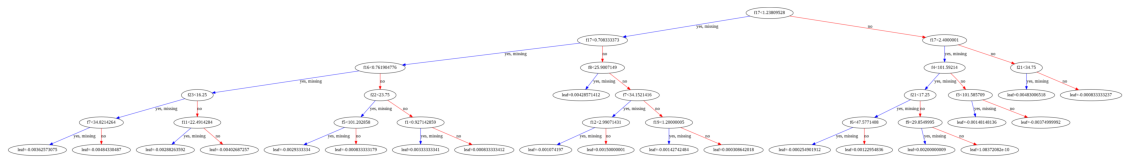

In [404]:
xgb.plot_tree(model,num_trees=0)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [442]:
model.fit(X_train, y_train.reshape(-1).ravel())
predictions_test = model.predict(X_test)
mse = (((predictions_test.reshape(-1) - y_test.reshape(-1)) ** 2).sum()) / len(predictions_test)

print("MSE : ", mse)

fig = go.Figure()

fig.add_trace(go.Scatter(y=np.around(y_test.reshape(-1)), name='True'))
fig.add_trace(go.Scatter(y=np.around(predictions_test).reshape(-1), name='Predicted'))
fig.show()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(y=np.around(y_test.reshape(-1))-np.around(predictions_test).reshape(-1), name='True'))
fig2.show()

print("Accuracy : {}%".format((1-np.count_nonzero(np.around(y_test.reshape(-1)*3)-np.around(predictions_test.reshape(-1)*3))/len(predictions_test))*100))

MSE :  0.017354508434693272


Accuracy : 85.16949152542372%


In [460]:
import datetime as dt
np.random.seed(0)

gandourie = shuffle(gandourie)
hists = []
accuracies = []
accuracies_std = []
xtrain_size = []
for h in range(1,14):
    hists.append(h)
    features_choosed = all_fields + ['mildew_leaves', 'mildew_bunches', 'stage', 'sprout']
    X_historic = []
    y_next = []
    length_hist = h

    for dom in ['Ligniere' , 'Magdeleine', 'Galliene']: #['Ligniere', 'Magdeleine']
        for annee in range(2012,2020):
            for parcel in parcel_names:
                X, y = get_history_data(gandourie, dom, parcel, features_choosed, annee, length_hist)
                X_historic = [*X_historic, *X]
                y_next = [*y_next, *y]
    X_historic_array = np.array(X_historic).reshape(len(X_historic), -1)
    y_next_array = np.array(y_next).reshape(len(y_next), 1)/3


    col_mean = np.nanmean(X_historic_array, axis=0)
    inds = np.where(np.isnan(X_historic_array))
    X_historic_array[inds] = np.take(col_mean, inds[1])

    col_mean = np.nanmean(y_next_array, axis=0)
    inds = np.where(np.isnan(y_next_array))
    y_next_array[inds] = np.take(col_mean, inds[1])

    indices = np.arange(X_historic_array.shape[0])
    np.random.shuffle(indices)

    X_historic_array = X_historic_array[indices]
    y_next_array = y_next_array[indices]

    kf = KFold(n_splits=3)
    kf.get_n_splits(X_historic_array)

    acc = []
    for i, (train_index, test_index) in enumerate(kf.split(X_historic_array)):
        print("\nKFold step n°", i+1)
        X_train, X_test = X_historic_array[train_index], X_historic_array[test_index]
        y_train, y_test = y_next_array[train_index], y_next_array[test_index]

        params = {'n_estimators': 500, 'max_depth': 100, 'min_samples_split': 10,
            'learning_rate': 0.01, 'loss': 'huber'}
        model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.99, learning_rate = 0.01,
                max_depth = 5, alpha = 0.2, n_estimators = 250, tree_method='exact')

        model.fit(X_train, y_train.reshape(-1))

        predictions_train = model.predict(X_train)
        mse = (((predictions_train.reshape(-1) - y_train.reshape(-1)) ** 2).sum()) / len(predictions_train)
        print("\t - Train MSE : ", mse)
        print("\t - Train Accuracy : {}%".format((1-np.count_nonzero(np.around(y_train.reshape(-1)*3)-np.around(predictions_train.reshape(-1)*3))/len(predictions_train))*100))

        predictions_test = model.predict(X_test)
        mse = (((predictions_test.reshape(-1) - y_test.reshape(-1)) ** 2).sum()) / len(predictions_test)
        print("\t - Test MSE : ", mse)
        print("\t - Test Accuracy : {}%".format((1-np.count_nonzero(np.around(y_test.reshape(-1)*3)-np.around(predictions_test.reshape(-1)*3))/len(predictions_test))*100))
        acc.append(1-np.count_nonzero(np.around(y_test.reshape(-1)*3)-np.around(predictions_test.reshape(-1)*3))/len(predictions_test))
    
    accuracies.append(np.mean(acc))
    accuracies_std.append(np.std(acc))
    xtrain_size.append(X_train.shape[0])


KFold step n° 1
	 - Train MSE :  0.01711192920150093
	 - Train Accuracy : 86.28428927680798%
	 - Test MSE :  0.02741214676434673
	 - Test Accuracy : 83.31257783312577%

KFold step n° 2
	 - Train MSE :  0.020905785592941525
	 - Train Accuracy : 83.67601246105919%
	 - Test MSE :  0.022387144427939428
	 - Test Accuracy : 82.29426433915212%

KFold step n° 3
	 - Train MSE :  0.020856254856445603
	 - Train Accuracy : 82.67912772585669%
	 - Test MSE :  0.020459954994293775
	 - Test Accuracy : 81.29675810473816%

KFold step n° 1
	 - Train MSE :  0.016587393378486127
	 - Train Accuracy : 87.04819277108433%
	 - Test MSE :  0.019813003128850388
	 - Test Accuracy : 86.29518072289156%

KFold step n° 2
	 - Train MSE :  0.014908248595048395
	 - Train Accuracy : 86.82228915662651%
	 - Test MSE :  0.023342881712071745
	 - Test Accuracy : 83.8855421686747%

KFold step n° 3
	 - Train MSE :  0.016084448708410762
	 - Train Accuracy : 87.87650602409639%
	 - Test MSE :  0.019039622818478867
	 - Test Accurac

In [462]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = hists, y=accuracies, name='Accurracy',
    mode="lines+text",
    textposition="top left",
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=accuracies_std,
            visible=True), text=xtrain_size))

fig.update_layout(
    title="Précision moyenne (écart-type) en fonction de la taille de l'historique",
    xaxis_title="Taille historique",
    yaxis_title="Précision",
    font=dict(
        size=12,
        color="#7f7f7f")
    )

fig.show()

# Search Best length history

In [94]:
import datetime as dt

#https://www.ethanrosenthal.com/2019/02/18/time-series-for-scikit-learn-people-part3/ FOR GETTING FIXED LENGTH HISTORY

gandourie['date'] = pd.to_datetime(gandourie['date'])

gandourie['annee'] = gandourie['date'].dt.year
gandourie['mois'] = gandourie['date'].dt.month
gandourie['jour'] = gandourie['date'].dt.day
gandourie['index_year'] = [0 for i in range(len(gandourie))]

# gandourie = shuffle(gandourie)

features_choosed = ['mildew_leaves', 'mildew_bunches', 'stage', 'pluvio', 'sprout', 'gab_arcures', 'blackrot_bunches', 'blackrot_leaves', 'temperature']
mse_history = []
for h in range(2,12):
    X_historic = []
    y_next = []
    length_hist = h

    for dom in ['Ligniere', 'Magdeleine']:
        for annee in range(2012,2020):
            for parcel in parcel_names:
                parcel_domain_temp = gandourie.loc[gandourie['parcel_name'] == parcel][gandourie['domain_name'] == dom]
                if len(parcel_domain_temp) !=0:
                    parcel_domain_year_temp = parcel_domain_temp[parcel_domain_temp['annee'] == 2012].sort_values(by='date')
                    for feat in features_choosed:
                        parcel_domain_year_temp[feat] = parcel_domain_year_temp[feat].fillna(parcel_domain_year_temp[feat].mean())
                    if len(parcel_domain_year_temp) > length_hist:
                        for i in range(length_hist, len(parcel_domain_year_temp)-1):
                            X_historic.append(parcel_domain_year_temp.iloc[i-length_hist:i][features_choosed].to_numpy())
                            y_next.append(parcel_domain_year_temp.iloc[i]['mildew_leaves'])

    X_historic_array = np.array(X_historic).reshape(len(X_historic), -1)
    X_historic_array.shape
    y_next_array = np.array(y_next).reshape(len(y_next), 1)/3
    y_next_array

    indices = np.arange(X_historic_array.shape[0])
    np.random.shuffle(indices)

    X_historic_array = X_historic_array[indices]
    y_next_array = y_next_array[indices]


    split = 0.8
    N = len(X_historic)

    X_train = X_historic_array[:int(N*split)]
    X_test = X_historic_array[int(N*split):]

    y_train = y_next_array[:int(N*split)]
    y_test = y_next_array[int(N*split):]

    X_valid, X_test = X_test[:int(len(X_test)*0.5)], X_test[int(len(X_test)*0.5):]
    y_valid, y_test = y_test[:int(len(y_test)*0.5)], y_test[int(len(y_test)*0.5):]

    ns = []
    mses = []

    h_val = []

    params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.005, 'loss': 'huber'}
    model = ensemble.GradientBoostingRegressor(**params)

    model.fit(X_train, y_train.reshape(-1).ravel())

    predictions_test = model.predict(X_test)
    mse = (((np.around(predictions_test).reshape(-1) - y_test.reshape(-1)) ** 2).sum()) / len(predictions_test)
    mse_history.append(mse)
    h_val.append(h)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.


In [96]:
fig = go.Figure()
fig = px.scatter(y=mse_history)
fig.show()
mse_history

[0.08788686434914839,
 0.0889412263221787,
 0.10529950685060682,
 0.09242870580330897,
 0.08905377137935279,
 0.08575606785924249,
 0.07643650221031174,
 0.06249966653327997,
 0.05333319835870857,
 0.05317085318192738]

# Bin

In [0]:
from statsmodels.tsa.arima_model import ARIMA

#https://medium.com/spikelab/forecasting-multiples-time-series-using-prophet-in-parallel-2515abd1a245 

#https://www.ethanrosenthal.com/2019/02/18/time-series-for-scikit-learn-people-part3/ FOR GETTING FIXED LENGTH HISTORY


In [0]:
ns = []
mses = []

for i in range(2,15):
    # model = KNeighborsRegressor(n_neighbors=i, p = 2, n_jobs =16, leaf_size=15)

    # params = {'n_estimators': 500, 'max_depth': i, 'min_samples_split': 2,
    #       'learning_rate': 0.005, 'loss': 'huber'}
    # model = ensemble.GradientBoostingRegressor(**params)

    model = ensemble.BaggingRegressor(base_estimator=ensemble.GradientBoostingRegressor(), n_estimators=i*10, random_state=0)
    
    model.fit(X_train, y_train.reshape(-1).ravel())

    predictions = model.predict(X_train)
    mse = (((predictions.reshape(-1) - y_train.reshape(-1)) ** 2).sum()) / len(predictions)
    ns.append(i)
    mses.append(mse)

fig = go.Figure()
print(min(mses))
print(mses.index(min(mses))+1)
fig = px.scatter(x=ns, y=mses)
fig.show()